# Multi modal model

In [35]:
%pip install yfinance
%pip install nltk
%pip install matplotlib
%pip install seaborn
%pip install wordcloud
%pip install torchvision
%pip install -U scikit-learn scipy matplotlib
%pip install pytorch-lightning
%pip install transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: nltk in c:\users\computing\appdata\local\programs\python\python311\lib\site-packages (3.8.1)




[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import yfinance as yf
import numpy as np
import pandas as pd
import glob
import re
import nltk
import nest_asyncio
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from calendar import monthrange
import numpy as np
import pandas as pd
import seaborn as sns
import re
import pickle
from datetime import datetime, timedelta, date
import pytz
import torch
import torch.nn as nn
import torch.utils.data as td
import sklearn
import pytorch_lightning as pl
from typing import List, Optional

from joblib import Parallel, delayed
import joblib
import nltk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import defaultdict,Counter
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
nltk.download('words')
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score

import torch

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Computing\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Fetch financial record from 1st January 2015 - 31st May 2021

In [37]:
start_date ='2015-01-01'
end_date = '2021-12-31'
price = yf.download("BTC-USD", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


# Compute Lagged price

In [38]:
price.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [39]:
price = price.reset_index()

In [40]:
price_2= price.Close.to_frame()
price['PriceChange'] = price['Close'].pct_change() * 100 
price['Label'] = np.where(price['PriceChange'] > 0, 1, 0)

price['change']=price_2.apply(lambda x: x/x.shift(1)-1)
price['log_change']=price_2.apply(lambda x: np.log(x)-np.log(x.shift(1)))
price['change_label']=price['change'].apply (lambda x: x>0.02)

In [41]:
price.head()

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,change_label
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550,NaN,0,NaN,NaN,False
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650,0.249172,1,0.002492,0.002489,False
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400,-10.776686,0,-0.107767,-0.114028,False
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100,-6.007853,0,-0.060079,-0.061959,False
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800,3.890684,1,0.038907,0.038169,True


In [42]:
price.shape

(2556, 12)

In [43]:
window = 14  # Number of periods for RSI calculation

# Calculate price changes
delta = price['Close'].diff()

# Calculate gains and losses
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)

# Calculate average gains and losses
avg_gain = gain.rolling(window=window).mean()
avg_loss = loss.rolling(window=window).mean()

# Calculate relative strength (RS) and RSI
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))

price['rsi'] = rsi


In [44]:
price.shape

(2556, 13)

In [45]:
price.tail(5)

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,change_label,rsi
2551,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.752840,1,0.007528,0.007500,False,52.409775
2552,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.332807,0,-0.003328,-0.003334,False,66.874820
2553,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-6.025943,0,-0.060259,-0.062151,False,53.368353
2554,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,-2.404228,0,-0.024042,-0.024336,False,40.817228
2555,2021-12-30,46490.605469,47879.964844,46060.312500,47178.125000,47178.125000,26686491018,1.579112,1,0.015791,0.015668,False,48.104370


In [46]:
price = price.dropna()

In [47]:
price.isnull().value_counts()

Date   Open   High   Low    Close  Adj Close  Volume  PriceChange  Label  change  log_change  change_label  rsi  
False  False  False  False  False  False      False   False        False  False   False       False         False    2543
Name: count, dtype: int64

In [48]:
price.describe()

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,rsi
count,2543,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2.543000e+03,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000
mean,2018-07-08 00:00:00,11216.605895,11524.372882,10880.364241,11233.189416,11233.189416,1.513741e+10,0.286988,0.545812,0.002870,0.002101,54.995269
min,2015-01-14 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,1.060090e+07,-37.169539,0.000000,-0.371695,-0.464730,4.699489
25%,2016-10-10 12:00:00,672.084503,682.961517,661.203979,672.985016,672.985016,1.004370e+08,-1.222883,0.000000,-0.012229,-0.012304,41.508309
50%,2018-07-08 00:00:00,6440.970215,6543.799805,6342.370117,6453.720215,6453.720215,5.375314e+09,0.208241,1.000000,0.002082,0.002080,55.069895
75%,2020-04-03 12:00:00,10371.066406,10654.814453,10147.165039,10372.579590,10372.579590,2.524040e+10,1.831734,1.000000,0.018317,0.018152,68.165608
max,2021-12-30 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,25.247169,1.000000,0.252472,0.225119,99.765628
std,NaN,15891.922186,16330.651939,15391.340417,15901.816648,15901.816648,2.028423e+10,3.898567,0.497995,0.038986,0.039311,18.469943


In [49]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2543 entries, 13 to 2555
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2543 non-null   datetime64[ns]
 1   Open          2543 non-null   float64       
 2   High          2543 non-null   float64       
 3   Low           2543 non-null   float64       
 4   Close         2543 non-null   float64       
 5   Adj Close     2543 non-null   float64       
 6   Volume        2543 non-null   int64         
 7   PriceChange   2543 non-null   float64       
 8   Label         2543 non-null   int32         
 9   change        2543 non-null   float64       
 10  log_change    2543 non-null   float64       
 11  change_label  2543 non-null   bool          
 12  rsi           2543 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(9), int32(1), int64(1)
memory usage: 250.8 KB


In [50]:
price_corr = price.drop(['Date'], axis=1)

In [51]:
price_corr.corr()

,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,change_label,rsi
Open,1.000000,0.999518,0.999057,0.998795,0.998795,0.729833,-0.022142,-0.040172,-0.022142,-0.023655,0.062735,-0.018562
High,0.999518,1.000000,0.999012,0.999479,0.999479,0.733329,-0.006247,-0.029798,-0.006247,-0.008300,0.077167,-0.015002
Low,0.999057,0.999012,1.000000,0.999377,0.999377,0.722262,-0.003431,-0.027766,-0.003431,-0.004445,0.070874,-0.012840
Close,0.998795,0.999479,0.999377,1.000000,1.000000,0.728765,0.008918,-0.019495,0.008918,0.007240,0.084167,-0.010335
Adj Close,0.998795,0.999479,0.999377,1.000000,1.000000,0.728765,0.008918,-0.019495,0.008918,0.007240,0.084167,-0.010335
Volume,0.729833,0.733329,0.722262,0.728765,0.728765,1.000000,-0.000936,-0.031087,-0.000936,-0.007772,0.091189,0.019148
PriceChange,-0.022142,-0.006247,-0.003431,0.008918,0.008918,-0.000936,1.000000,0.653452,1.000000,0.997802,0.663022,0.271431
Label,-0.040172,-0.029798,-0.027766,-0.019495,-0.019495,-0.031087,0.653452,1.000000,0.653452,0.649354,0.506363,0.230590
change,-0.022142,-0.006247,-0.003431,0.008918,0.008918,-0.000936,1.000000,0.653452,1.000000,0.997802,0.663022,0.271431
log_change,-0.023655,-0.008300,-0.004445,0.007240,0.007240,-0.007772,0.997802,0.649354,0.997802,1.000000,0.645698,0.273623


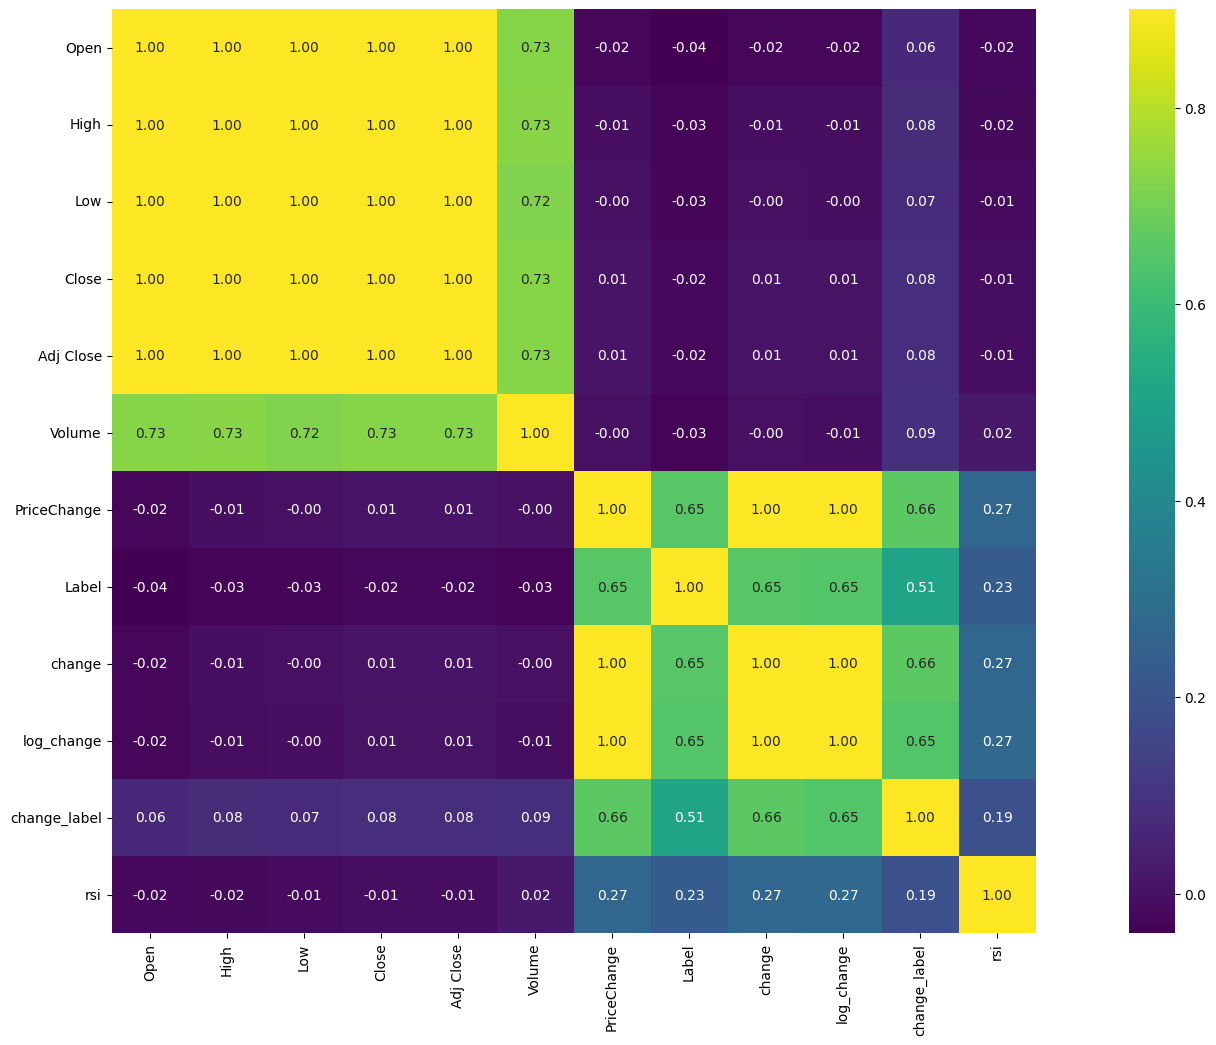

In [52]:
corrmat = price_corr.corr()

ax = plt.subplots(figsize = (24, 12))

sns.heatmap(corrmat, vmax = 0.9, square = True, annot = True, fmt = '0.2f', cmap = 'viridis');

c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Computing\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Label', ylabel='count'>

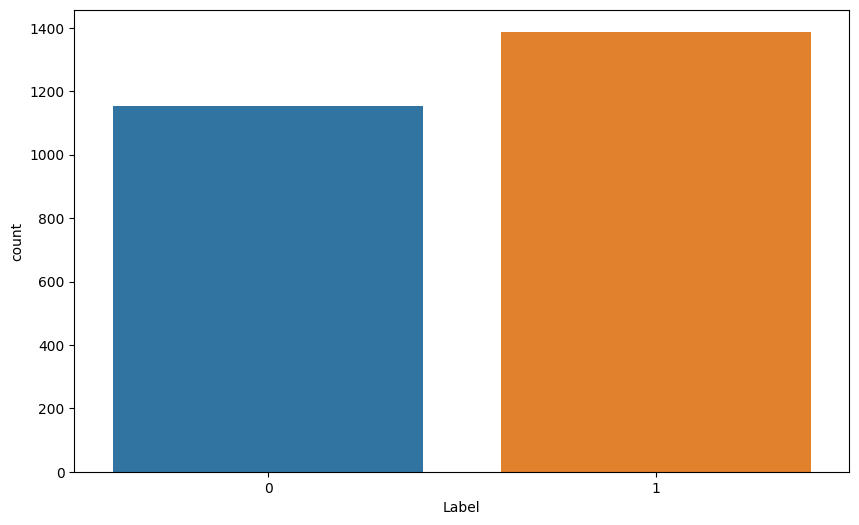

In [53]:
plt.figure(figsize = (10, 6))

sns.countplot(x='Label', data = price)

In [54]:
price['Label'].value_counts()

Label
1    1388
0    1155
Name: count, dtype: int64

In [179]:
# price.skew()

<Figure size 1200x600 with 0 Axes>

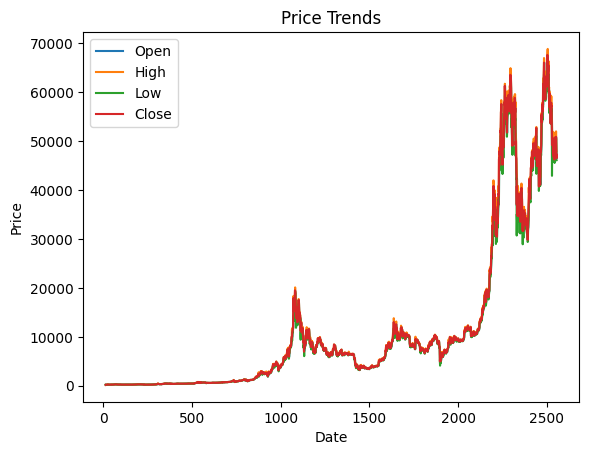

In [55]:
# Plotting Open, High, Low, Close
plt.figure(figsize=(12, 6))
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title('Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

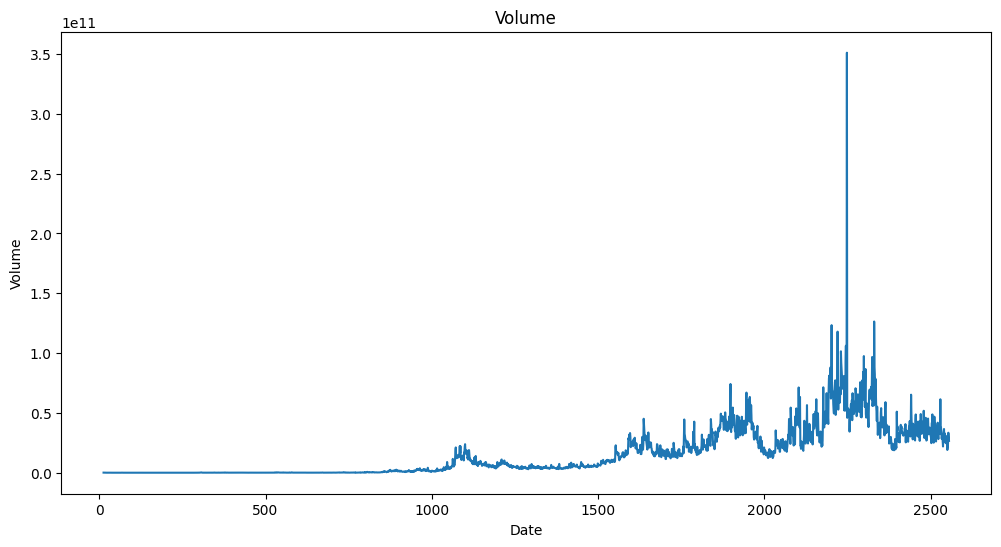

In [56]:
# Plotting Volume
plt.figure(figsize=(12, 6))
price['Volume'].plot()
plt.title('Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

In [ ]:
# Plotting Moving Averages
plt.figure(figsize=(12, 6))
price[['sma7', 'sma14', 'sma21']].plot()
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

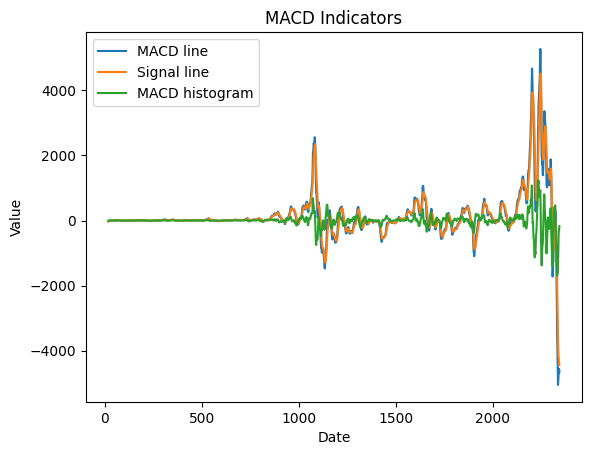

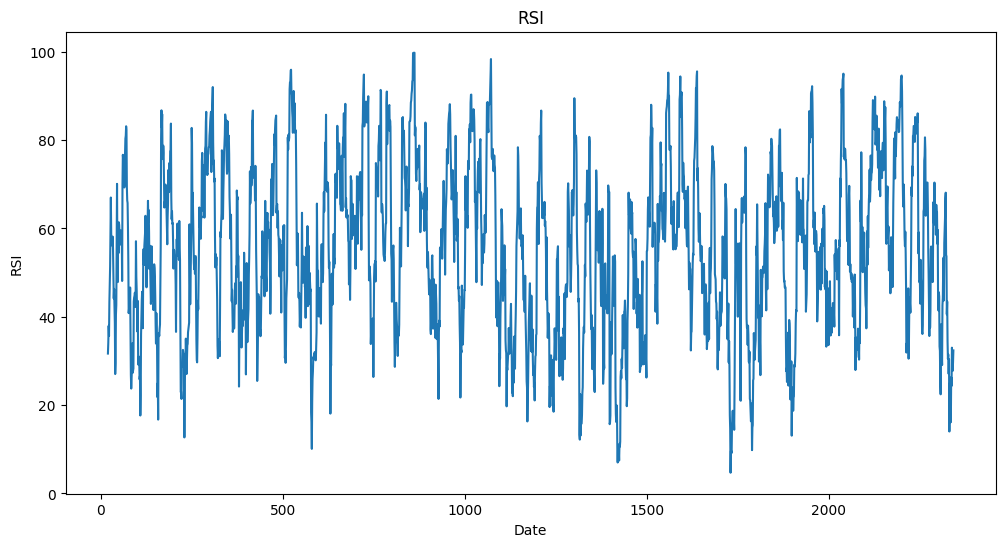

In [183]:
# Plotting MACD Line, Signal Line, MACD Histogram
plt.figure(figsize=(12, 6))
price[['MACD line', 'Signal line', 'MACD histogram']].plot()
plt.title('MACD Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# Plotting RSI
plt.figure(figsize=(12, 6))
price['rsi'].plot()
plt.title('RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.show()

In [184]:
price.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2323 entries, 20 to 2342
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                2323 non-null   object 
 1   Open                2323 non-null   float64
 2   High                2323 non-null   float64
 3   Low                 2323 non-null   float64
 4   Close               2323 non-null   float64
 5   Adj Close           2323 non-null   float64
 6   Volume              2323 non-null   int64  
 7   Close Lagged Price  2323 non-null   float64
 8   sma7                2323 non-null   float64
 9   sma14               2323 non-null   float64
 10  sma21               2323 non-null   float64
 11  ema12               2323 non-null   float64
 12  ema26               2323 non-null   float64
 13  MACD line           2323 non-null   float64
 14  Signal line         2323 non-null   float64
 15  MACD histogram      2323 non-null   float64
 16  PriceChang

# Process tweets

In [62]:
price

,Date,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,change_label,rsi
13,2015-01-14,223.893997,223.893997,171.509995,178.102997,178.102997,97638704,-21.144862,0,-0.211449,-0.237558,False,18.540940
14,2015-01-15,176.897003,229.067001,176.897003,209.843994,209.843994,81773504,17.821709,1,0.178217,0.164002,True,28.961378
15,2015-01-16,209.070007,221.591003,199.770996,208.097000,208.097000,38421000,-0.832520,0,-0.008325,-0.008360,False,28.534947
16,2015-01-17,207.834000,211.731003,194.875000,199.259995,199.259995,23469700,-4.246580,0,-0.042466,-0.043394,False,31.734361
17,2015-01-18,200.050003,218.695007,194.505997,210.339005,210.339005,30085100,5.560077,1,0.055601,0.054110,True,37.657329
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551,2021-12-26,50428.691406,51196.378906,49623.105469,50809.515625,50809.515625,20964372926,0.752840,1,0.007528,0.007500,False,52.409775
2552,2021-12-27,50802.609375,51956.328125,50499.468750,50640.417969,50640.417969,24324345758,-0.332807,0,-0.003328,-0.003334,False,66.874820
2553,2021-12-28,50679.859375,50679.859375,47414.210938,47588.855469,47588.855469,33430376883,-6.025943,0,-0.060259,-0.062151,False,53.368353
2554,2021-12-29,47623.871094,48119.742188,46201.496094,46444.710938,46444.710938,30049226299,-2.404228,0,-0.024042,-0.024336,False,40.817228


In [73]:
tweets_2015 = pd.read_csv('../archive/data/tweets/combined_tweets_2015_labeled.csv')
tweets_2016 = pd.read_csv('../archive/data/tweets/combined_tweets_2016_labeled.csv')
tweets_2017 = pd.read_csv('../archive/data/tweets/combined_tweets_2017_labeled.csv')
tweets_2018 = pd.read_csv('../archive/data/tweets/combined_tweets_2018_labeled.csv')
tweets_2019 = pd.read_csv('../archive/data/tweets/combined_tweets_2019_apr_dec_labeled.csv')
tweets_2020 = pd.read_csv('../archive/data/tweets/combined_tweets_2020_labeled.csv')
tweets_2021 = pd.read_csv('../archive/data/tweets/combined_tweets_2021_jan_may_labeled.csv')

In [87]:
frames = [tweets_2015,tweets_2016,tweets_2017,tweets_2018,tweets_2019,tweets_2020,tweets_2021]
tweets = pd.concat(frames,ignore_index=True)

In [88]:
tweets.rename(columns={"date": "Date"}, inplace=True)

In [76]:
tweets

,Unnamed: 0,Date,text_split,label_up5,label_up2,label_down5,label_down2
0,0,2015-01-01,blocked me thats my achievement still like bit...,False,False,False,False
1,1,2015-01-01,accept here is bitcoin tip via claim it here c...,False,False,False,False
2,2,2015-01-01,btc bitcoin current price btc bitcoin parking ...,False,False,False,False
3,3,2015-01-01,revolution don miss out your bitcoin tip about...,False,False,False,False
4,4,2015-01-01,cap billion based on bitcoin informative my da...,False,False,False,False
...,...,...,...,...,...,...,...
342057,31805,2021-05-31,bitcoin claim free bitcoin bitcoin price sugge...,True,True,False,True
342058,31806,2021-05-31,het roulette het is wat of twitter deal gift s...,True,True,False,True
342059,31807,2021-05-31,longer it stays in this range it will be it go...,True,True,False,True
342060,31808,2021-05-31,en el video para el de media el de en ya para ...,True,True,False,True


In [90]:
tweets = tweets.drop_duplicates(subset=['Date'])

In [91]:
tweets

,Unnamed: 0,Date,text_split,label_up5,label_up2,label_down5,label_down2
0,0,2015-01-01,blocked me thats my achievement still like bit...,False,False,False,False
64,64,2015-01-02,bitcoin my brother and have just our first me ...,False,False,False,False
143,143,2015-01-03,bitcoin btc new post cryptocurrency trading ne...,False,False,True,True
228,228,2015-01-04,in the last there were exchange pair yielding ...,False,False,True,True
308,308,2015-01-05,can wait to get my tax refund and buy bitcoin ...,True,True,False,False
...,...,...,...,...,...,...,...
341031,30779,2021-05-27,bitcoin cryptocurrency money the central histo...,False,True,True,True
341235,30983,2021-05-28,what to do when bitcoin price crash bitcoin to...,False,False,True,True
341439,31187,2021-05-29,great project and hope it will achieve lots of...,False,True,True,True
341660,31408,2021-05-30,rager was do that too but like it will take of...,True,True,False,True


In [92]:
tweets = tweets.drop(['label_up5','label_up2','label_down5','label_down2','Unnamed: 0'],axis=1)

In [93]:
tweets

,Date,text_split
0,2015-01-01,blocked me thats my achievement still like bit...
64,2015-01-02,bitcoin my brother and have just our first me ...
143,2015-01-03,bitcoin btc new post cryptocurrency trading ne...
228,2015-01-04,in the last there were exchange pair yielding ...
308,2015-01-05,can wait to get my tax refund and buy bitcoin ...
...,...,...
341031,2021-05-27,bitcoin cryptocurrency money the central histo...
341235,2021-05-28,what to do when bitcoin price crash bitcoin to...
341439,2021-05-29,great project and hope it will achieve lots of...
341660,2021-05-30,rager was do that too but like it will take of...


In [80]:
price['Date'] = pd.to_datetime(price['Date'])

In [94]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [95]:
f = tweets.merge(price,how='outer',on=['Date'])

In [96]:
f = f.dropna()

In [97]:
f

,Date,text_split,Open,High,Low,Close,Adj Close,Volume,PriceChange,Label,change,log_change,change_label,rsi
13,2015-01-14,the of tinder talk bitcoin via bitcoin big fou...,223.893997,223.893997,171.509995,178.102997,178.102997,9.763870e+07,-21.144862,0.0,-0.211449,-0.237558,False,18.540940
14,2015-01-15,in daily trading vol behind only bitcoin and l...,176.897003,229.067001,176.897003,209.843994,209.843994,8.177350e+07,17.821709,1.0,0.178217,0.164002,True,28.961378
15,2015-01-16,bitcoin conference tomorrow right planetary pl...,209.070007,221.591003,199.770996,208.097000,208.097000,3.842100e+07,-0.832520,0.0,-0.008325,-0.008360,False,28.534947
16,2015-01-17,visa para en it when my chais on bitcoin news ...,207.834000,211.731003,194.875000,199.259995,199.259995,2.346970e+07,-4.246580,0.0,-0.042466,-0.043394,False,31.734361
17,2015-01-18,bitcoin price now this is how it more bitcoin ...,200.050003,218.695007,194.505997,210.339005,210.339005,3.008510e+07,5.560077,1.0,0.055601,0.054110,True,37.657329
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2242,2021-05-27,bitcoin cryptocurrency money the central histo...,39316.890625,40379.617188,37247.902344,38436.968750,38436.968750,4.321097e+10,-2.181570,0.0,-0.021816,-0.022057,False,30.743726
2243,2021-05-28,what to do when bitcoin price crash bitcoin to...,38507.082031,38856.968750,34779.039062,35697.605469,35697.605469,5.520019e+10,-7.126897,0.0,-0.071269,-0.073936,False,27.743299
2244,2021-05-29,great project and hope it will achieve lots of...,35684.156250,37234.500000,33693.929688,34616.066406,34616.066406,4.523101e+10,-3.029724,0.0,-0.030297,-0.030766,False,29.639910
2245,2021-05-30,rager was do that too but like it will take of...,34607.406250,36400.667969,33520.738281,35678.128906,35678.128906,3.164608e+10,3.068120,1.0,0.030681,0.030220,True,32.378224


In [99]:
from sklearn.model_selection import train_test_split

In [100]:
sentence = f['text_split'].values
label = f['change_label'].map({True: 1, False: 0})

In [101]:
label

13      0
14      1
15      0
16      0
17      1
       ..
2242    0
2243    0
2244    0
2245    1
2246    1
Name: change_label, Length: 2234, dtype: int64

In [102]:
sentence_train,sentence_test, label_train,label_test = train_test_split(sentence, label,test_size=0.25, random_state=1000)

In [103]:
from keras.preprocessing.text import Tokenizer

tokenizer  = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence_train)


In [104]:
xcnn_train = tokenizer.texts_to_sequences(sentence_train)
xcnn_test = tokenizer.texts_to_sequences(sentence_test)
vocab_size = len(tokenizer.word_index) + 1

In [108]:
%pip install keras_preprocessing


  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras_preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D

In [110]:
maxlen = 200
xcnn_train = pad_sequences(xcnn_train,padding='post', maxlen=maxlen)

xcnn_test = pad_sequences(xcnn_test, padding='post',maxlen=maxlen)

In [111]:
embedding_dim = 200
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim,input_length=maxlen))
model.add(Conv1D(128,5,activation='relu'))
model.add(MaxPooling1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          1914800   
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          128128    
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 128)           0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 98, 10)            1290      
                                                                 
 dense_1 (Dense)             (None, 98, 1)             11        
                                                                 
Total params: 2044229 (7.80 MB)
Trainable params: 2044229 (7.80 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [112]:
model.fit(xcnn_train, label_train, epochs=2, verbose=True, validation_data=(xcnn_test,label_test),batch_size=10)

Epoch 1/2
168/168 [==============================] - 4s 21ms/step - loss: 0.5628 - accuracy: 0.7591 - val_loss: 0.5516 - val_accuracy: 0.7603
Epoch 2/2
168/168 [==============================] - 3s 20ms/step - loss: 0.5324 - accuracy: 0.7660 - val_loss: 0.5655 - val_accuracy: 0.7602


In [113]:
print(vocab_size)
print(sentence_train[1])
print(xcnn_train[1])

9574
btc bitcoin exchange comedic billboard campaign btc ai the generation of perpetual swap trade with up to leverage on platform built by former now to participate in giveaway bitcoin btc crypto eth two year false de em anterior the first non narcotic non home kit short term moon must watch btc market analysis now let get this crypto bitcoin cryptocurrency de um de em um bitcoin las bitcoin new airdrop to you get for token giveaway cryptocurrency eth bitcoin btc money earn bounty invest bitcoin is days away on via cryptocurrency market learn to survive them because bitcoin will always outlast them as it always over the last remember how you felt at the top of the market and act on that bitcoin so far it now unprofitable to even mine it las bitcoin bitcoin is here to stay satellite expansion sure of it two year false and climate change to bitcoin mining and indoor marijuana production the of the film is simple darkness human potential electricity it if you had bought of bitcoin the to

In [ ]:
tokenizer

In [ ]:
len(tweets['text_split'][3])

1099

In [ ]:
# tweets = tweets.drop(columns=['date', 'label_up5','label_up2','label_down5','label_down2'])

In [ ]:
tweets.shape

(2247, 2)

In [ ]:
tweets

,Date,text_split
0,2015-01-01,blocked me thats my achievement still like bit...
1,2015-01-02,bitcoin my brother and have just our first me ...
2,2015-01-03,bitcoin btc new post cryptocurrency trading ne...
3,2015-01-04,in the last there were exchange pair yielding ...
4,2015-01-05,can wait to get my tax refund and buy bitcoin ...
...,...,...
2242,2021-05-27,bitcoin cryptocurrency money the central histo...
2243,2021-05-28,what to do when bitcoin price crash bitcoin to...
2244,2021-05-29,great project and hope it will achieve lots of...
2245,2021-05-30,rager was do that too but like it will take of...


In [ ]:

# tweets['Date']=tweets.Date.apply (lambda x : str(x)[:10])

In [ ]:
tweets['Date'] = pd.to_datetime(tweets['Date'])

In [ ]:
price['Date'] = pd.to_datetime(price['Date'])

In [ ]:
price_tweets = tweets.merge(price, how='outer', on=['Date'])

In [ ]:
price_tweets.head()

,Date,text_split,Open,High,Low,Close,Adj Close,Volume,sma7,sma14,sma21,ema12,ema26,MACD line,Signal line,MACD histogram,change,log_change,change_label,rsi
0,2015-01-01,blocked me thats my achievement still like bit...,320.434998,320.434998,314.002991,314.248993,314.248993,8036550.0,NaN,NaN,NaN,319.278532,319.752697,-0.474165,-0.094833,-0.379332,-0.018564,-0.018738,False,NaN
1,2015-01-02,bitcoin my brother and have just our first me ...,314.079010,315.838989,313.565002,315.032013,315.032013,7860650.0,NaN,NaN,NaN,318.625221,319.403017,-0.777796,-0.231426,-0.546370,0.002492,0.002489,True,NaN
2,2015-01-03,bitcoin btc new post cryptocurrency trading ne...,314.846008,315.149994,281.082001,281.082001,281.082001,33054400.0,NaN,NaN,NaN,312.849341,316.564423,-3.715082,-0.928157,-2.786925,-0.107767,-0.114028,False,NaN
3,2015-01-04,in the last there were exchange pair yielding ...,281.145996,287.230011,257.612000,264.195007,264.195007,55629100.0,NaN,NaN,NaN,305.364059,312.685207,-7.321148,-2.206755,-5.114393,-0.060079,-0.061959,False,NaN
4,2015-01-05,can wait to get my tax refund and buy bitcoin ...,265.084015,278.341003,265.084015,274.473999,274.473999,43962800.0,NaN,NaN,NaN,300.611742,309.854747,-9.243005,-3.614005,-5.629000,0.038907,0.038169,True,NaN


In [ ]:
price_tweets.shape

(2344, 20)

## Word embeddings

#### Now that we have our dataset, let's get the word embedding for the news articles

In [ ]:
%pip install transformers torch

In [115]:
from transformers import AutoModel, AutoTokenizer

model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [116]:
def processEmbeddings(text):
    tokens = tokenizer.tokenize(text)

    # Set the maximum segment length and overlap
    max_segment_length = 200
    overlap = 50

    # Initialize lists to store embeddings and segment tokens
    embeddings_list = []
    segment_tokens_list = []

    # Slide a window over the tokens and process each segment
    for start in range(0, len(tokens), max_segment_length - overlap):
        end = start + max_segment_length
        segment_tokens = tokens[start:end]

        # Convert segment tokens back to text and encode
        segment_text = tokenizer.convert_tokens_to_string(segment_tokens)
        inputs = tokenizer(segment_text, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state[:, 0, :]

        embeddings_list.append(embeddings)
        segment_tokens_list.append(segment_tokens)

    # Combine embeddings and segment tokens for the entire text
    all_embeddings = torch.cat(embeddings_list, dim=0)
    # all_segment_tokens = sum(segment_tokens_list, [])
    
    return all_embeddings


In [117]:
f['text_embedding'] = f['text_split'].apply(processEmbeddings)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
f['text_embedding']

In [ ]:
# Replace True with 1 and False with 0
price_tweets['change_label'] = price_tweets['change_label'].map({True: 1, False: 0})

C:\Users\HP\AppData\Local\Temp\ipykernel_15080\3128454574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_tweets['change_label'] = price_tweets['change_label'].map({True: 1, False: 0})


In [ ]:
price_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 19 to 2245
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             2227 non-null   datetime64[ns]
 1   text_split       2227 non-null   object        
 2   Open             2227 non-null   float64       
 3   High             2227 non-null   float64       
 4   Low              2227 non-null   float64       
 5   Close            2227 non-null   float64       
 6   Adj Close        2227 non-null   float64       
 7   Volume           2227 non-null   float64       
 8   sma7             2227 non-null   float64       
 9   sma14            2227 non-null   float64       
 10  sma21            2227 non-null   float64       
 11  ema12            2227 non-null   float64       
 12  ema26            2227 non-null   float64       
 13  MACD line        2227 non-null   float64       
 14  Signal line      2227 non-null   float6

### Build the architecture

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential,Model
from keras.layers import LSTM, Dense, Embedding, Input, concatenate,Conv2D,Conv1D,Flatten,BatchNormalization, MaxPooling2D,MaxPooling1D

In [ ]:
features = price_tweets[['text_embeddings']]
target = price_tweets['change_label']

In [ ]:
target

19      0
20      1
21      1
22      0
23      1
       ..
2241    1
2242    0
2243    0
2244    0
2245    1
Name: change_label, Length: 2227, dtype: int64

In [ ]:
# features = price_tweets.drop(['change_label', 'Date'], axis=1)  # Adjust columns as needed
# target = price_tweets['change_label']

In [ ]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1726 entries, 383 to 2108
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               1726 non-null   float64
 1   Open                1726 non-null   float64
 2   High                1726 non-null   float64
 3   Low                 1726 non-null   float64
 4   Close               1726 non-null   float64
 5   Adj Close           1726 non-null   float64
 6   Volume              1726 non-null   float64
 7   Close Lagged Price  1726 non-null   float64
 8   sma7                1726 non-null   float64
 9   sma14               1726 non-null   float64
 10  sma21               1726 non-null   float64
 11  ema12               1726 non-null   float64
 12  ema26               1726 non-null   float64
 13  MACD line           1726 non-null   float64
 14  Signal line         1726 non-null   float64
 15  MACD histogram      1726 non-null   float64
 16  chan

In [ ]:
# Split the data into training, validation, and testing sets
# First, split into training and temp sets (80% training, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(features, target, test_size=0.2, random_state=42)

# Then, split the temp set into validation and testing sets (50% validation, 50% testing)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Normalize numerical features for each set
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.drop('text_embeddings', axis=1))
# X_val_scaled = scaler.transform(X_val.drop('text_embeddings', axis=1))
# X_test_scaled = scaler.transform(X_test.drop('text_embeddings', axis=1))


### Build CNN model

In [ ]:
def cnn(embedding_dim):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=(embedding_dim, 1)))
    model.add(MaxPooling1D(2))
    # model.add(Conv1D(128, 3, activation='relu'))
    # model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # model.add(Conv1D(filters=16, kernel_size=(3,3), activation="relu",input_shape=(embedding_dim,)))

    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
    
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
    
    # model.add(MaxPooling2D(pool_size=(2,2)))

    # model.add(Flatten())

    # model.add(Dense(64,activation='relu'))

    # model.add(Dense(1,activation='sigmoid'))

    # model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model


In [ ]:
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]

In [ ]:
model = cnn(embedding_dim)

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 766, 64)           256       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 383, 64)          0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 24512)             0         
                                                                 
 dense_12 (Dense)            (None, 128)               3137664   
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,138,049
Trainable params: 3,138,049
Non-trainable params: 0
____________________________________________

In [ ]:
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]

In [ ]:
# Build the LSTM model for text embeddings
embedding_dim = X_train.iloc[0]['text_embeddings'].shape[0]
text_input = Input(shape=(embedding_dim,), name='text_input')
text_lstm = Dense(64, activation='relu')(text_input)

In [ ]:
# Build the LSTM model for numerical features
num_features_input = Input(shape=(X_train_scaled.shape[1],), name='num_features_input')
num_lstm = Dense(64, activation='relu')(num_features_input)

In [ ]:
# Combine the outputs of both LSTM models
concatenated = concatenate([text_lstm, num_lstm])

In [ ]:
# Build the final prediction layer
output = Dense(1, activation='sigmoid')(concatenated)

In [ ]:
# Create the multi-modal model
model = Model(inputs=[text_input, num_features_input], outputs=output)

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
data = features['text_embeddings']

In [ ]:
target.info()

<class 'pandas.core.series.Series'>
Int64Index: 2227 entries, 19 to 2245
Series name: change_label
Non-Null Count  Dtype
--------------  -----
2227 non-null   int64
dtypes: int64(1)
memory usage: 34.8 KB


In [ ]:
import tensorflow as tf


In [ ]:
model.fit(data, np.array(target),validation_split=0.4, epochs=3)

In [ ]:
# Train the model
model.fit([np.array(X_train['text_embeddings']), X_train_scaled], y_train,
          epochs=10, batch_size=32, validation_data=([np.array(X_test['text_embeddings'].tolist()), X_test], y_test))


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate([np.array(X_test['text_embeddings'].tolist()), X_test_scaled], y_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")

6/6 [==============================] - 0s 4ms/step - loss: 0.1413 - accuracy: 0.9653
Loss: 0.1412552446126938, Accuracy: 0.9653179049491882
